February 2023 Challenge: Mentorship Program Screening Tasks

In [1]:
!pip show qiskit

Name: qiskit
Version: 0.41.1
Summary: Software for developing quantum computing programs
Home-page: https://qiskit.org/
Author: Qiskit Development Team
Author-email: hello@qiskit.org
License: Apache 2.0
Location: /opt/conda/lib/python3.9/site-packages
Requires: qiskit-aer, qiskit-ibmq-provider, qiskit-terra
Required-by: qiskit-qir


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator
import numpy as np

### Task 1 Find the largest number

Algorithm for finding the largest number between two integers, either positive or negative, is based on Grover's search algorithm with modifications in the Oracle part. The number of qubits required for the algorithm are equal to the maximum number of bits, either positive or negative, because of usage abs values. This allowed us to encode positive and negative numbers in the same states that simplified Oracle implementation to mark search solution state.

In [13]:
"""
    We are creating a custom oracle that has only one solution state, which is
    determined by a maximum number. To accomplish this, we can utilize an Operator
    class that allows us to abstract away from the specific implementation of the
    gate used to mark the desired solution state.
"""
def create_oracle(nqubits: int, max_number: int):
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr, name='Oracle(max)')

    gate_matrix = np.eye(2 ** nqubits, dtype=int)
    i=abs(max_number)
    gate_matrix[i][i] = -1

    max_operator = Operator(gate_matrix)
    qc.unitary(max_operator, range(nqubits))
    
    return qc.to_instruction()

def create_diffuser(nqubits: int):
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr, name='Diffuser')

    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.barrier(range(nqubits))
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    qc.barrier(range(nqubits))
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)

    return qc.to_instruction()

def find_the_largest_number(number_1: int, number_2: int):
    max_number = max(number_1, number_2)
    nqubits = max(max(abs(number_1), abs(number_2)).bit_length(), 2)
    nstates = 2 ** nqubits

    qc = QuantumCircuit(nqubits)

    for i in range(nqubits):
        qc.h(i)

    niterations = int(np.floor(np.pi/4 * np.sqrt(nstates)))
    for i in range(niterations):
        qc.append(create_oracle(nqubits, max_number), range(nqubits))
        qc.append(create_diffuser(nqubits), range(nqubits))

    qc.measure_all()
       
    aer_sim = Aer.get_backend('aer_simulator')
    compiled_circuit = transpile(qc, aer_sim)
    result = aer_sim.run(compiled_circuit).result()
    counts = result.get_counts()
    max_candidate = int(max(counts, key=counts.get), 2)

    if abs(max_number) == max_candidate:
        return max_number
    else:
        return None

In [16]:
A = find_the_largest_number(5, -6)

        ┌───┐┌──────────────┐┌───────────┐┌──────────────┐┌───────────┐ ░ ┌─┐»
   q_0: ┤ H ├┤0             ├┤0          ├┤0             ├┤0          ├─░─┤M├»
        ├───┤│              ││           ││              ││           │ ░ └╥┘»
   q_1: ┤ H ├┤1 Oracle(max) ├┤1 Diffuser ├┤1 Oracle(max) ├┤1 Diffuser ├─░──╫─»
        ├───┤│              ││           ││              ││           │ ░  ║ »
   q_2: ┤ H ├┤2             ├┤2          ├┤2             ├┤2          ├─░──╫─»
        └───┘└──────────────┘└───────────┘└──────────────┘└───────────┘ ░  ║ »
meas: 3/═══════════════════════════════════════════════════════════════════╩═»
                                                                           0 »
«              
«   q_0: ──────
«        ┌─┐   
«   q_1: ┤M├───
«        └╥┘┌─┐
«   q_2: ─╫─┤M├
«         ║ └╥┘
«meas: 3/═╩══╩═
«         1  2 


**Another implementation based on Qiskit library**

In [3]:
from qiskit.algorithms import AmplificationProblem, Grover
from qiskit.quantum_info import Statevector
from qiskit.primitives import Sampler

In [4]:
def find_the_largest_number_v2(number_1: int, number_2: int):
    max_number = max(number_1, number_2)
    solution = format(abs(max_number), 'b').zfill(2)
    mark_state = Statevector.from_label(solution)
    problem = AmplificationProblem(oracle=mark_state, is_good_state=[solution])
    grover = Grover(sampler=Sampler())
    result = grover.amplify(problem)
    if abs(max_number) == int(result.top_measurement, 2):
        return max_number
    else:
        return None

In [18]:
A = find_the_largest_number(5, -6)
print(A)
A = find_the_largest_number_v2(5, -6)
print(A)

5
5


### References
1. https://learn.qiskit.org/course/introduction/grovers-search-algorithm
2. https://qiskit.org/documentation/stable/0.24/tutorials/algorithms/07_grover.html?highlight=grover

### Task 2 Is Rectangle?

The main approach to solving the current task is to encode all possible solutions or no solution in the oracle. We can then use quantum counting to attempt to find at least one solution that matches the given sides. To achieve this, we need to create an oracle that maps each possible solution to a unique state in the quantum register. This can be done by encoding the solutions as a binary string and using the corresponding basis states in the quantum register. To achieve that we need a maximum of 3 qubits (6 combinations). Overall, the key idea is to use quantum computing techniques to efficiently search for a solution among a "large" number of possible solutions.

In [5]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import Diagonal, GroverOperator, QFT
from qiskit.visualization import plot_histogram

import numpy as np
import math
from itertools import permutations
from typing import Union

In [6]:
ONE_SOLUTION = [7]
SIX_SOLUTIONS = [1, 2, 3, 4, 5, 6]
NO_SOLUTION = []

def encode_solutions(sides: [int]) -> Union[None, list[int]]:
    if max(sides) == 0:
        return NO_SOLUTION
        
    A, B, C, D = sides
    if A == B and B == C and C == D:
        return ONE_SOLUTION
    elif A == B and C == D:
        return SIX_SOLUTIONS
    elif A == C and B == D:
        return SIX_SOLUTIONS
    elif A == D and B == C:
        return SIX_SOLUTIONS
    else:
        return NO_SOLUTION

In [7]:
encode_solutions([0, 0, 0, 0]), encode_solutions([0, 0, 0, 1]), encode_solutions([1, 1, 1, 1]), encode_solutions([1, 2, 1, 2]), encode_solutions([1, 2, 1, 3]),

([], [], [7], [1, 2, 3, 4, 5, 6], [])

In [11]:
def mark_solutions(n_qubits: int, states: [int]) -> [int]:
    diagonal = np.ones(2 ** n_qubits)
    for s in states:
        diagonal[s] = -1
    return diagonal

def QFT_inverse(n_qubits: int):
    qft_dagger = QFT(n_qubits, inverse=True).to_gate()
    qft_dagger.label = "QFT†"
    return qft_dagger

def grover_operator(n_iterations, solutions: [int]):
    oracle = Diagonal(solutions)
    grover_it = GroverOperator(oracle).repeat(n_iterations).to_gate()
    grover_it.label = f"Grover$^{n_iterations}$"
    return grover_it

In [9]:
def is_rectangle(A: int, B: int, C: int, D: int) -> bool:
    sides = [A, B, C, D]
    enc_rectangles = encode_solutions(sides)

    t = 3  # no. of counting qubits, max value can be 6 so 3 qubits must be enought
    n = 3  # no. of searching qubits

    marked_solutions = mark_solutions(n, enc_rectangles)

    qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

    # Initialize all qubits to |+>
    for qubit in range(t+n):
        qc.h(qubit)

    # Begin controlled Grover iterations
    n_iterations = 1
    for qubit in range(t):
        cgrit = grover_operator(n_iterations, marked_solutions).control()
        qc.append(cgrit, [qubit] + list(range(t, n+t)))
        n_iterations *= 2

    # Do inverse QFT on counting qubits
    qc.append(QFT_inverse(n), range(t))

    # Measure counting qubits
    qc.measure(range(t), range(t))

    # Execute and see results
    sim = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, sim)
    job = sim.run(transpiled_qc)
    hist = job.result().get_counts()
    plot_histogram(hist)

    measured_str = max(hist, key=hist.get)
    measured_int = int(measured_str, 2)
    print("Register Output = %i" % measured_int)

    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)

    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print(f"No. of Solutions = {M:.1f}")

    return M > 0

In [12]:
is_rectangle(1, 1, 1, 1)

Register Output = 1
Theta = 0.78540
No. of Solutions = 1.2


True

In [36]:
is_rectangle(0, 0, 0, 0)

Register Output = 0
Theta = 0.00000
No. of Solutions = 0.0


False

In [38]:
is_rectangle(0, 0, 0, 1)

Register Output = 0
Theta = 0.00000
No. of Solutions = 0.0


False

In [39]:
is_rectangle(1, 2, 1, 2)

Register Output = 3
Theta = 2.35619
No. of Solutions = 6.8


True

### References
1. https://learn.qiskit.org/course/ch-algorithms/quantum-counting

### Task 3 QSVM

To build classifier for iris dataset based on QSVM we need to execute the following steps:
1. Encode data as qubits this is the role of the feature map.
2. Apply a parameterized quantum circuit.
3. Train classifier (QSVN).
4. Validate model.

So in total we have 150 samples for 50 samples in each class and there are four features (attributes) in each sample.

In [10]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [11]:
features, labels = iris_data.data, iris_data.target

In [12]:
print(iris_data.DESCR[600:1000])

          Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========


#### Feature normalization

In [13]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

In [6]:
features[0:5]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667]])

In [14]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.7, random_state=algorithm_globals.random_seed
)

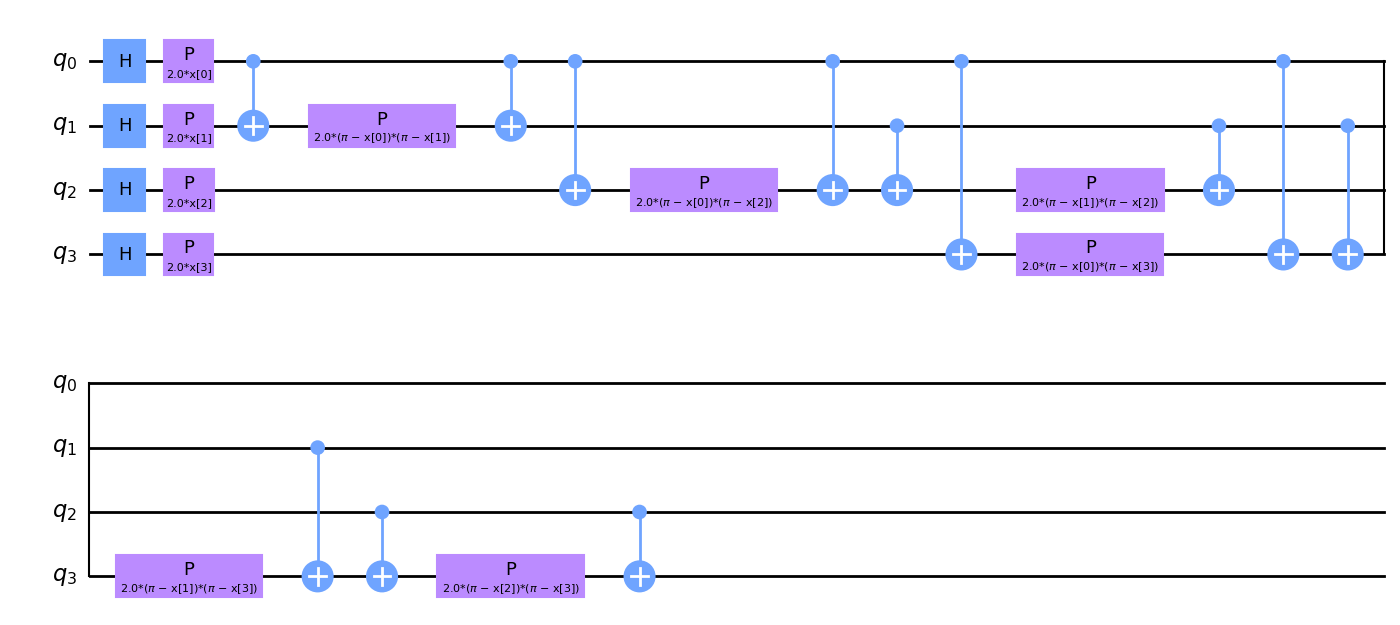

In [19]:
from qiskit.circuit.library import ZZFeatureMap

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

In [20]:
import time
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import QSVC
from qiskit.algorithms.state_fidelities import ComputeUncompute

sampler = Sampler()

fidelity=ComputeUncompute(
    sampler=sampler,
)

qkernel=FidelityQuantumKernel(
    feature_map=feature_map,
    fidelity=fidelity
)

qsvc = QSVC(
    quantum_kernel=qkernel,
)

In [21]:
start = time.time()
qsvc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Training time: 32 seconds


In [22]:
train_score = qsvc.score(train_features, train_labels)
test_score = qsvc.score(test_features, test_labels)

print(f"QSVC on the training dataset: {train_score:.2f}")
print(f"QSVC on the test dataset:     {test_score:.2f}")

QSVC on the training dataset: 0.99
QSVC on the test dataset:     0.96


### References
1. https://qiskit.org/documentation/stable/0.24/tutorials/machine_learning/01_qsvm_classification.html?highlight=machine%20learning